
# Assignment Set 12

by **Amir Mehrpanah** for Deep Learing Course at Data Science Center, SBU


(871, 1542)


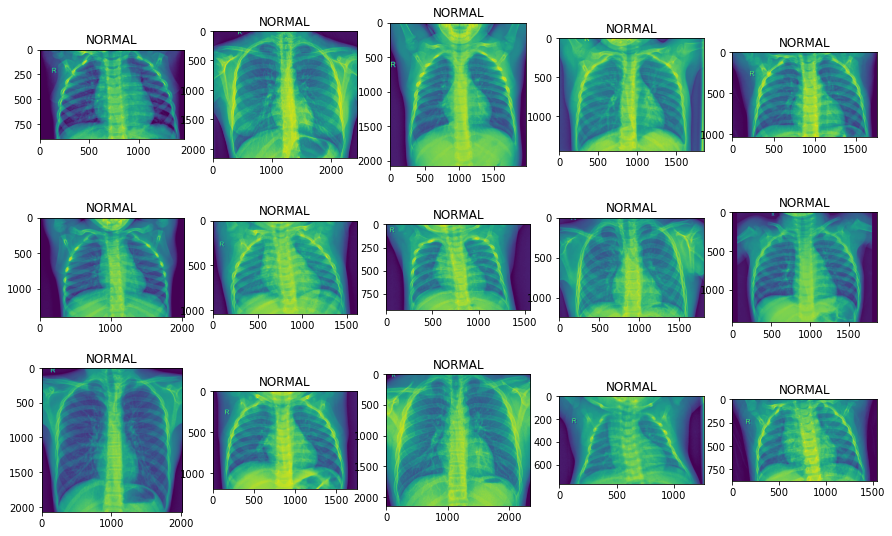

In [ ]:
root = '/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/'
files = glob.glob(root+'train/NORMAL/*.jpeg')
fig, axes = plt.subplots(3,5, figsize=(15,9))
for i,ax in enumerate(axes.flat):
    x = plt.imread(files[i])
    y = files[i].split('/')[-2]
    ax.imshow(x)
    ax.set_title(y)
print(x.shape)      

In [ ]:
data_transform = transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.Resize((675,675)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

train_ds = datasets.ImageFolder(root=root+'train/',
                                           transform=data_transform)
training_generator = torch.utils.data.DataLoader(train_ds,
                                             batch_size=32, shuffle=True)

val_ds = datasets.ImageFolder(root=root+'test/',
                                           transform=data_transform)
validation_generator = torch.utils.data.DataLoader(val_ds,
                                             batch_size=32, shuffle=True)

In [ ]:
opt_functional = lambda x:optim.Adadelta(x.parameters(),lr=.5)
loss_function = nn.CrossEntropyLoss()

In [ ]:
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        self.fc1 = nn.Linear(1000, 500)
        self.fc2 = nn.Linear(500, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 2)
        
    def forward(self, x):
        x = self.resnet18(x)
        x = F.relu(self.fc1(x))
        x = nn.Dropout(p=0.3)(x)   
        x = F.relu(self.fc2(x))
        x = nn.Dropout(p=0.2)(x) 
        x = F.relu(self.fc3(x))
        x = nn.Dropout(p=0.2)(x) 
        x = torch.softmax(self.fc4(x),dim=1)
        return x
    
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.alexnet = models.alexnet(pretrained=True)
        self.fc1 = nn.Linear(1000, 500)
        self.fc2 = nn.Linear(500, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 2)
        
    def forward(self, x):
        x = self.alexnet(x)
        x = F.relu(self.fc1(x))
        x = nn.Dropout(p=0.3)(x)   
        x = F.relu(self.fc2(x))
        x = nn.Dropout(p=0.2)(x) 
        x = F.relu(self.fc3(x))
        x = nn.Dropout(p=0.2)(x) 
        x = torch.softmax(self.fc4(x),dim=1)
        return x

In [ ]:
max_epochs = 10
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)
torch.backends.cudnn.benchmark = True
cnn_dic = {'AlexNet':AlexNet(),
           'ResNet18':ResNet18()}
mdl_pool = {}
for name,cnn in cnn_dic.items():
    print('training '+name)
    optimizer = opt_functional(cnn)
    cnn.to(device)
    train_epoch_loss = [] 
    train_epoch_acc = [] 
    val_epoch_loss = []
    val_epoch_acc = [] 
    for epoch in range(max_epochs):
        cnn.train()
        running_loss = []
        running_acc = []
        for local_batch, local_labels in training_generator:
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            optimizer.zero_grad()
            outputs = cnn(local_batch)
            loss = loss_function(outputs, local_labels)
            loss.backward()
            optimizer.step()
            running_loss += [loss.item()]
            _, predicted = torch.max(outputs, 1)
            running_acc += [(predicted == local_labels).sum().item()/training_generator.batch_size]
        train_epoch_loss += [np.mean(running_loss)]
        train_epoch_acc += [np.mean(running_acc)]
        
        running_loss = []
        running_acc = []
        with torch.no_grad():
            cnn.eval()
            for local_batch, local_labels in validation_generator:
                local_batch, local_labels = local_batch.to(device), local_labels.to(device)
                outputs = cnn(local_batch)
                loss = loss_function(outputs, local_labels)
                running_loss += [loss.item()]
                _, predicted = torch.max(outputs, 1)
                running_acc += [(predicted == local_labels).sum().item()/validation_generator.batch_size]

        val_epoch_loss += [np.mean(running_loss)]
        val_epoch_acc += [np.mean(running_acc)]
        print('[{:d}] loss: {:7.5f} - acc: {:%} - val loss: {:7.5f} - val acc: {:%}'.format(epoch + 1,
                                                                                            train_epoch_loss[-1],
                                                                                            train_epoch_acc[-1],
                                                                                            val_epoch_loss[-1],
                                                                                            val_epoch_acc[-1]))
    mdl_pool[name]={}
    mdl_pool[name]['loss'] = train_epoch_loss
    mdl_pool[name]['acc'] = train_epoch_acc
    mdl_pool[name]['val_loss'] = val_epoch_loss
    mdl_pool[name]['val_acc'] = val_epoch_acc

cuda:0
training AlexNet
[1] loss: 0.69691 - acc: 50.625000% - val loss: 0.53902 - val acc: 56.250000%
[2] loss: 0.68245 - acc: 56.875000% - val loss: 0.75616 - val acc: 31.250000%
[3] loss: 0.69602 - acc: 49.375000% - val loss: 0.70113 - val acc: 17.187500%
[4] loss: 0.70094 - acc: 48.750000% - val loss: 0.68647 - val acc: 31.250000%
[5] loss: 0.69349 - acc: 46.250000% - val loss: 0.67452 - val acc: 43.750000%
[6] loss: 0.64209 - acc: 65.000000% - val loss: 0.68697 - val acc: 29.687500%
[7] loss: 0.69421 - acc: 43.750000% - val loss: 0.70707 - val acc: 31.250000%
[8] loss: 0.66288 - acc: 52.500000% - val loss: 0.76593 - val acc: 31.250000%
[9] loss: 0.79642 - acc: 46.250000% - val loss: 0.65932 - val acc: 31.250000%
[10] loss: 0.64617 - acc: 63.750000% - val loss: 0.63048 - val acc: 32.812500%
training ResNet18
[1] loss: 0.63264 - acc: 73.125000% - val loss: 0.55766 - val acc: 50.000000%
[2] loss: 0.36707 - acc: 91.250000% - val loss: 0.39049 - val acc: 57.812500%
[3] loss: 0.48078 - a

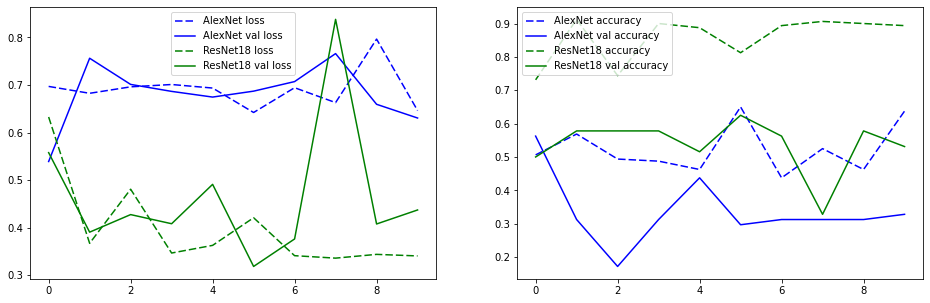

In [ ]:
plt.figure(figsize=(16,5))
c = ['b', 'g', 'r', 'c']
plt.subplot(121)
for i,(name,item) in enumerate(mdl_pool.items()):
    plt.plot(item['loss'],linestyle=(0,(5,2)),color=c[i],label = name+' loss')
    plt.plot(item['val_loss'],color=c[i],label = name+' val loss')
plt.legend()

plt.subplot(122)
for i,(name,item) in enumerate(mdl_pool.items()):
    plt.plot(item['acc'],linestyle=(0,(5,2)),color=c[i],label = name +' accuracy')
    plt.plot(item['val_acc'],color=c[i],label = name+' val accuracy')
plt.legend()